In [2]:
import gym
import gym_anytrading
import os

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf

2023-07-01 01:17:38.032205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 01:17:39.124714: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def genreate_stock_data(stock_name,period):
    company = yf.Ticker(stock_name)
    df = company.history(period=period)
    
    #Sepreate the dates of the stock for further use if required
    date = (df.reset_index())['Date']
    #-------------------------------------------------------------------------------------------------------------
    
    #Remove data object from the database
    df = (df.reset_index()).drop('Date',axis=1)
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the current trend of the current stock
    t = []
    for i in range(len(df)):
        if(df['Open'].iloc[i]-df['Close'].iloc[i]>0):
            t.append("DOWN")
        else:
            t.append("UP")
            
    df['Trend']=t
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the trend history of the stock
    th=[0]
    current_trend = df['Trend'].iloc[0]
    count = 0
    for i in range(1,len(df)):
        if(current_trend==df['Trend'].iloc[i]):
            count+=1
            th.append(count)
        else:
            count = 0
            th.append(count)
            current_trend = df['Trend'].iloc[i]
            
    df["Trend history"]=th
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the comparison to the change since last peak
    p=[]
    v=[]
    if(df['Trend'].iloc[0]=="DOWN"):
        peak = df['Open'].iloc[0]
        valley = df['Close'].iloc[0]
    else:
        valley = df['Open'].iloc[0]
        peak = df['Close'].iloc[0]

    for i in range(0,len(df)):

        p.append(peak-df['Close'].iloc[i])
        v.append(valley-df['Close'].iloc[i])

        if peak<df['Close'].iloc[i]:
            peak = df['Close'].iloc[i]
        if valley>df['Close'].iloc[i]:
            valley = df['Close'].iloc[i]
            
    df['Change since last peak']=p
    df['Change since last drop']=v
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the local change of daily stock
    c=[]
    cm=[]
    for i in range(0,len(df)):
        c.append(df['Open'].iloc[i]-df['Close'].iloc[i])
        cm.append(df['High'].iloc[i]-df['Low'].iloc[i])

    df['Local Change']=c
    df['Local range of stock price']=cm
    #-------------------------------------------------------------------------------------------------------------
    
    #Create dummy variable for the categorical variable
    df = pd.get_dummies(df,drop_first=True)
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the label for the change from tommorow, the data that needs to be predicted
    next_day_change = df[1:]
    next_day_change = next_day_change['Local Change']
    #-------------------------------------------------------------------------------------------------------------
    
    #Remove The last column as the it is redundant
    df.drop(index=df.index[-1],axis=0,inplace=True)
    #-------------------------------------------------------------------------------------------------------------
    
    #Break the data into features and labels
    X = df
    y = next_day_change
    #-------------------------------------------------------------------------------------------------------------
    
    return(date,X,y)

In [4]:
def bot_work(stock):
    date,X,y = genreate_stock_data(stock,'max')
    X['Date']=date
    X.set_index(['Date'],inplace=True)
    env_maker = lambda: gym.make('stocks-v0', df=X, frame_bound=(5,100), window_size=5)
    env = DummyVecEnv([env_maker])
    model = A2C('MlpPolicy', env, verbose=1) 
    model.learn(total_timesteps=100)
    env = gym.make('stocks-v0', df=X,frame_bound = (900,1000),window_size=5)
    obs = env.reset()
    while True: 
        obs = obs[np.newaxis, ...]
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        if done:
            print("info", info)
            break
    
    path = path = 'models/'+stock+'/trading_bot/'
    
    if not os.path.isdir(path):
        os.makedirs(path)
    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.show()
    plt.savefig(path+'bot_evaluation.png')

/home/om/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 2)
  logger.warn(
/home/om/.local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device


/home/om/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/om/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/om/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/home/om/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is wri

info {'total_reward': 0.05133599042892456, 'total_profit': 0.8006501740279798, 'position': 1}


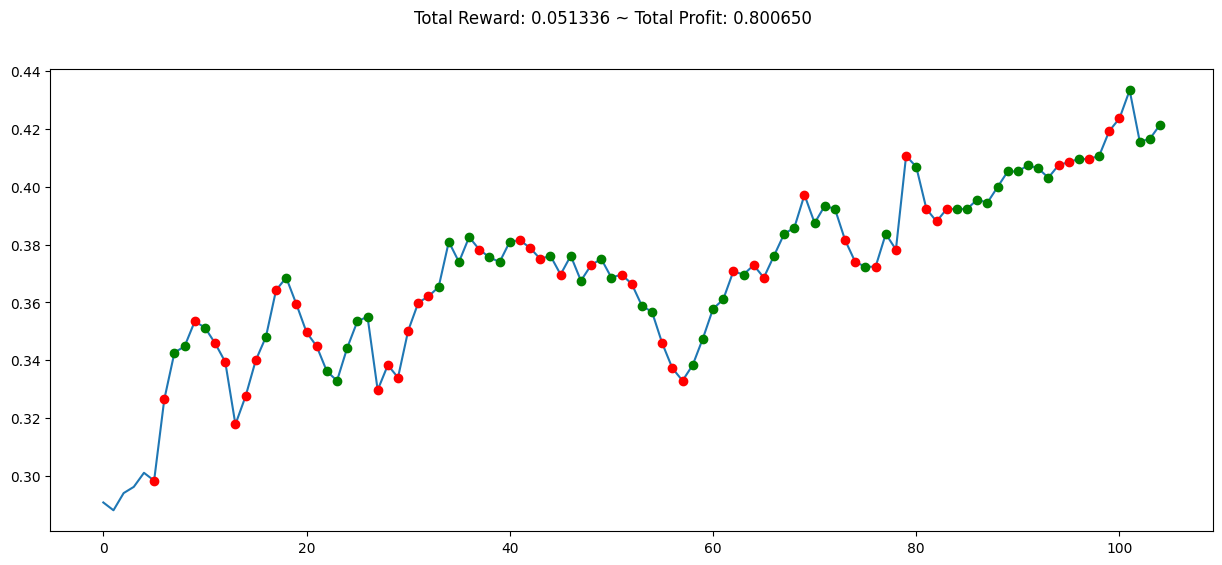

<Figure size 640x480 with 0 Axes>

In [5]:
bot_work('MSFT')

In [6]:
date,X,y = genreate_stock_data('GME','max')

In [7]:
X['Date']=date

In [8]:
X.set_index(['Date'],inplace=True)

In [9]:
X = X.iloc[::-1]

In [10]:
env_maker = lambda: gym.make('stocks-v0', df=X, frame_bound=(5,100), window_size=5)
env = DummyVecEnv([env_maker])

/home/om/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 2)
  logger.warn(
/home/om/.local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [11]:
model = A2C('MlpPolicy', env, verbose=1) 
model.learn(total_timesteps=100000)

/home/om/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/om/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/om/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/home/om/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is wri

Using cuda device
------------------------------------
| time/                 |          |
|    fps                | 395      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.636   |
|    explained_variance | 0.0264   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.128   |
|    value_loss         | 0.033    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 405      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.249   |
|    explained_variance | -38.1    |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 0.000135 |
|    value_loss     

-------------------------------------
| time/                 |           |
|    fps                | 397       |
|    iterations         | 1700      |
|    time_elapsed       | 21        |
|    total_timesteps    | 8500      |
| train/                |           |
|    entropy_loss       | -0.049    |
|    explained_variance | -1.67     |
|    learning_rate      | 0.0007    |
|    n_updates          | 1699      |
|    policy_loss        | -8.59e-07 |
|    value_loss         | 1.26e-07  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 398       |
|    iterations         | 1800      |
|    time_elapsed       | 22        |
|    total_timesteps    | 9000      |
| train/                |           |
|    entropy_loss       | -0.0389   |
|    explained_variance | -35.6     |
|    learning_rate      | 0.0007    |
|    n_updates          | 1799      |
|    policy_loss        | -2.94e-05 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 393       |
|    iterations         | 3300      |
|    time_elapsed       | 41        |
|    total_timesteps    | 16500     |
| train/                |           |
|    entropy_loss       | -0.004    |
|    explained_variance | 0.274     |
|    learning_rate      | 0.0007    |
|    n_updates          | 3299      |
|    policy_loss        | -5.85e-08 |
|    value_loss         | 1.78e-08  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 393       |
|    iterations         | 3400      |
|    time_elapsed       | 43        |
|    total_timesteps    | 17000     |
| train/                |           |
|    entropy_loss       | -0.00401  |
|    explained_variance | -3.56     |
|    learning_rate      | 0.0007    |
|    n_updates          | 3399      |
|    policy_loss        | -3.28e-08 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 390       |
|    iterations         | 4900      |
|    time_elapsed       | 62        |
|    total_timesteps    | 24500     |
| train/                |           |
|    entropy_loss       | -0.000776 |
|    explained_variance | -2.54     |
|    learning_rate      | 0.0007    |
|    n_updates          | 4899      |
|    policy_loss        | -4.96e-10 |
|    value_loss         | 1.47e-10  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 390       |
|    iterations         | 5000      |
|    time_elapsed       | 63        |
|    total_timesteps    | 25000     |
| train/                |           |
|    entropy_loss       | -0.000777 |
|    explained_variance | -28.6     |
|    learning_rate      | 0.0007    |
|    n_updates          | 4999      |
|    policy_loss        | 9.71e-12  |
|    value_l

------------------------------------
| time/                 |          |
|    fps                | 387      |
|    iterations         | 6500     |
|    time_elapsed       | 83       |
|    total_timesteps    | 32500    |
| train/                |          |
|    entropy_loss       | -0.00078 |
|    explained_variance | -51.5    |
|    learning_rate      | 0.0007   |
|    n_updates          | 6499     |
|    policy_loss        | 1.25e-08 |
|    value_loss         | 3.05e-08 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 387       |
|    iterations         | 6600      |
|    time_elapsed       | 85        |
|    total_timesteps    | 33000     |
| train/                |           |
|    entropy_loss       | -0.000779 |
|    explained_variance | 0.00474   |
|    learning_rate      | 0.0007    |
|    n_updates          | 6599      |
|    policy_loss        | 2.95e-07  |
|    value_loss         | 

------------------------------------
| time/                 |          |
|    fps                | 380      |
|    iterations         | 8100     |
|    time_elapsed       | 106      |
|    total_timesteps    | 40500    |
| train/                |          |
|    entropy_loss       | -0.00078 |
|    explained_variance | -0.0223  |
|    learning_rate      | 0.0007   |
|    n_updates          | 8099     |
|    policy_loss        | 3.37e-08 |
|    value_loss         | 2.51e-07 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 379      |
|    iterations         | 8200     |
|    time_elapsed       | 107      |
|    total_timesteps    | 41000    |
| train/                |          |
|    entropy_loss       | -0.00078 |
|    explained_variance | -0.16    |
|    learning_rate      | 0.0007   |
|    n_updates          | 8199     |
|    policy_loss        | 9.13e-08 |
|    value_loss         | 1.88e-06 |
-

-------------------------------------
| time/                 |           |
|    fps                | 371       |
|    iterations         | 9700      |
|    time_elapsed       | 130       |
|    total_timesteps    | 48500     |
| train/                |           |
|    entropy_loss       | -0.000338 |
|    explained_variance | -0.149    |
|    learning_rate      | 0.0007    |
|    n_updates          | 9699      |
|    policy_loss        | 2.86e-09  |
|    value_loss         | 1.2e-08   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 369       |
|    iterations         | 9800      |
|    time_elapsed       | 132       |
|    total_timesteps    | 49000     |
| train/                |           |
|    entropy_loss       | -0.000338 |
|    explained_variance | 0.0802    |
|    learning_rate      | 0.0007    |
|    n_updates          | 9799      |
|    policy_loss        | -6.3e-10  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 354       |
|    iterations         | 11300     |
|    time_elapsed       | 159       |
|    total_timesteps    | 56500     |
| train/                |           |
|    entropy_loss       | -0.000338 |
|    explained_variance | 0.0139    |
|    learning_rate      | 0.0007    |
|    n_updates          | 11299     |
|    policy_loss        | 2.56e-08  |
|    value_loss         | 9.32e-07  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 354       |
|    iterations         | 11400     |
|    time_elapsed       | 160       |
|    total_timesteps    | 57000     |
| train/                |           |
|    entropy_loss       | -0.000338 |
|    explained_variance | -0.187    |
|    learning_rate      | 0.0007    |
|    n_updates          | 11399     |
|    policy_loss        | 1.4e-09   |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 353       |
|    iterations         | 12900     |
|    time_elapsed       | 182       |
|    total_timesteps    | 64500     |
| train/                |           |
|    entropy_loss       | -0.000337 |
|    explained_variance | 0.411     |
|    learning_rate      | 0.0007    |
|    n_updates          | 12899     |
|    policy_loss        | 6.28e-10  |
|    value_loss         | 5.77e-10  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 353       |
|    iterations         | 13000     |
|    time_elapsed       | 183       |
|    total_timesteps    | 65000     |
| train/                |           |
|    entropy_loss       | -0.000337 |
|    explained_variance | -11.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 12999     |
|    policy_loss        | 7.38e-11  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 353       |
|    iterations         | 14500     |
|    time_elapsed       | 205       |
|    total_timesteps    | 72500     |
| train/                |           |
|    entropy_loss       | -0.000335 |
|    explained_variance | -0.109    |
|    learning_rate      | 0.0007    |
|    n_updates          | 14499     |
|    policy_loss        | 7.74e-10  |
|    value_loss         | 8.69e-10  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 352       |
|    iterations         | 14600     |
|    time_elapsed       | 206       |
|    total_timesteps    | 73000     |
| train/                |           |
|    entropy_loss       | -0.000335 |
|    explained_variance | -0.0793   |
|    learning_rate      | 0.0007    |
|    n_updates          | 14599     |
|    policy_loss        | -4.17e-09 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 346       |
|    iterations         | 16100     |
|    time_elapsed       | 232       |
|    total_timesteps    | 80500     |
| train/                |           |
|    entropy_loss       | -0.000146 |
|    explained_variance | 0.558     |
|    learning_rate      | 0.0007    |
|    n_updates          | 16099     |
|    policy_loss        | -9.94e-12 |
|    value_loss         | 3.63e-12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 346       |
|    iterations         | 16200     |
|    time_elapsed       | 233       |
|    total_timesteps    | 81000     |
| train/                |           |
|    entropy_loss       | -0.000146 |
|    explained_variance | -2.67     |
|    learning_rate      | 0.0007    |
|    n_updates          | 16199     |
|    policy_loss        | -2.62e-11 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 344       |
|    iterations         | 17700     |
|    time_elapsed       | 256       |
|    total_timesteps    | 88500     |
| train/                |           |
|    entropy_loss       | -0.000146 |
|    explained_variance | -86.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 17699     |
|    policy_loss        | -1.71e-10 |
|    value_loss         | 2.43e-10  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 344       |
|    iterations         | 17800     |
|    time_elapsed       | 258       |
|    total_timesteps    | 89000     |
| train/                |           |
|    entropy_loss       | -0.000147 |
|    explained_variance | -11.9     |
|    learning_rate      | 0.0007    |
|    n_updates          | 17799     |
|    policy_loss        | 5.04e-10  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 338       |
|    iterations         | 19300     |
|    time_elapsed       | 285       |
|    total_timesteps    | 96500     |
| train/                |           |
|    entropy_loss       | -0.000146 |
|    explained_variance | -1.59     |
|    learning_rate      | 0.0007    |
|    n_updates          | 19299     |
|    policy_loss        | -1.78e-10 |
|    value_loss         | 2.99e-10  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 338       |
|    iterations         | 19400     |
|    time_elapsed       | 286       |
|    total_timesteps    | 97000     |
| train/                |           |
|    entropy_loss       | -0.000146 |
|    explained_variance | 0.0617    |
|    learning_rate      | 0.0007    |
|    n_updates          | 19399     |
|    policy_loss        | 6.35e-10  |
|    value_l

In [12]:
env = gym.make('stocks-v0', df=X,frame_bound = (900,1000),window_size=5)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 0.0, 'total_profit': 0.7508097987259061, 'position': 1}
